### 1. Gerekli Kütüphanelerin Yüklenmesi
Bu aşamada, veri işleme için Pandas/Numpy ve modelleme için güçlü Gradient Boosting kütüphaneleri olan **XGBoost** ve **LightGBM** yüklenir. Ayrıca başarım ölçümleri (ROC AUC, F1-Score vb.) için gerekli modüller import edilir.

In [1]:
!pip install xgboost lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


Defaulting to user installation because normal site-packages is not writeable


In [2]:
df = pd.read_csv("googleplaystore.csv")

print("Dataset Shape:", df.shape)
print("Columns:")
print(df.columns.tolist())
print("\nPreview:")
print(df.head().to_string(index=False))


Dataset Shape: (10841, 13)
Columns:
['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']

Preview:
                                               App       Category  Rating Reviews Size    Installs Type Price Content Rating                    Genres     Last Updated        Current Ver  Android Ver
    Photo Editor & Candy Camera & Grid & ScrapBook ART_AND_DESIGN     4.1     159  19M     10,000+ Free     0       Everyone              Art & Design  January 7, 2018              1.0.0 4.0.3 and up
                               Coloring book moana ART_AND_DESIGN     3.9     967  14M    500,000+ Free     0       Everyone Art & Design;Pretend Play January 15, 2018              2.0.0 4.0.3 and up
U Launcher Lite – FREE Live Cool Themes, Hide Apps ART_AND_DESIGN     4.7   87510 8.7M  5,000,000+ Free     0       Everyone              Art & Design   August 1, 2018              1.2.4 4.0.3 and up
  

### 2. Veri Setinin Yüklenmesi ve Hedef Değişken Tanımı
Google Play Store verisi yüklenir. Sınıflandırma problemi yaratmak için `Rating` sütunu üzerinden yeni bir hedef değişken (`High_Rating`) türetilir:
* **1 (Başarılı):** Puanı 4.0 ve üzeri olanlar.
* **0 (Başarısız):** Puanı 4.0'ın altında olanlar.
Bu işlem, problemi bir regresyon probleminden ikili sınıflandırma (binary classification) problemine dönüştürür.

In [3]:
print("Missing Rating before:", df['Rating'].isna().sum())
df = df.loc[df['Rating'].notna()].copy()

df['High_Rating'] = (df['Rating'] >= 4.0).astype(int)

print("Target distribution:")
print(df['High_Rating'].value_counts())
print("\nTarget distribution (normalized):")
print(df['High_Rating'].value_counts(normalize=True))

Missing Rating before: 1474
Target distribution:
High_Rating
1    7369
0    1998
Name: count, dtype: int64

Target distribution (normalized):
High_Rating
1    0.786698
0    0.213302
Name: proportion, dtype: float64


### 3. Veri Temizleme ve Sayısal Dönüşüm
Modelin doğru çalışabilmesi için:
* Eksik veriler (NaN) temizlenir.
* `Reviews`, `Installs` ve `Price` gibi sayısal olması gereken ancak metin formatında olan sütunlardaki özel karakterler ('+', '$', ',') temizlenerek sayısal formata çevrilir.

In [4]:

before_rows = df.shape[0]
df = df.dropna(subset=['Reviews', 'Installs', 'Price'])
after_rows = df.shape[0]

print(f"Rows before cleaning: {before_rows}")
print(f"Rows after cleaning : {after_rows}")

Rows before cleaning: 9367
Rows after cleaning : 9367


In [5]:

# Reviews
df.loc[:, 'Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Installs
df.loc[:, 'Installs'] = (
    df['Installs']
    .astype(str)
    .str.replace('[+,]', '', regex=True)
)
df.loc[:, 'Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Price
df.loc[:, 'Price'] = (
    df['Price']
    .astype(str)
    .str.replace('$', '', regex=True)
)
df.loc[:, 'Price'] = pd.to_numeric(df['Price'], errors='coerce')

print("Missing values after numeric conversion:")
print(df[['Reviews', 'Installs', 'Price']].isna().sum())


Missing values after numeric conversion:
Reviews       1
Installs      1
Price       648
dtype: int64


### 4. Özellik Seçimi ve Veri Ayrımı
Modelde kullanılacak özellikler (X) ve hedef değişken (y) belirlenir. Veri seti, modelin performansını objektif ölçebilmek için **Eğitim (%80)** ve **Test (%20)** olarak ikiye ayrılır. `stratify=y` parametresi ile hedef değişkenin sınıf dengesinin korunması sağlanır.

In [6]:
features = ['Reviews', 'Installs', 'Price']
X = df[features]
y = df['High_Rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nFeature statistics:")
print(X.describe())

X shape: (9367, 3)
y shape: (9367,)

Feature statistics:
        Reviews   Installs   Price
count    9366.0     9366.0  8719.0
unique   5992.0       19.0     1.0
top         2.0  1000000.0     0.0
freq       83.0     1577.0  8719.0


In [7]:

features = ['Reviews', 'Installs', 'Price']

X = df[features].astype(float)
y = df['High_Rating']

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nFeature statistics:")
print(X.describe())


X shape: (9367, 3)
y shape: (9367,)

Feature statistics:
            Reviews      Installs   Price
count  9.366000e+03  9.366000e+03  8719.0
mean   5.140498e+05  1.789744e+07     0.0
std    3.144042e+06  9.123822e+07     0.0
min    1.000000e+00  1.000000e+00     0.0
25%    1.862500e+02  1.000000e+04     0.0
50%    5.930500e+03  5.000000e+05     0.0
75%    8.153275e+04  5.000000e+06     0.0
max    7.815831e+07  1.000000e+09     0.0


In [8]:


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)


Train size: (7493, 3)
Test size : (1874, 3)


In [9]:

features = ['Reviews', 'Installs', 'Price']

df[features] = df[features].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=features)

X = df[features].astype(float)
y = df['High_Rating']

print("\nFeature dtypes (must be numeric):")
print(X.dtypes)



Feature dtypes (must be numeric):
Reviews     float64
Installs    float64
Price       float64
dtype: object


### 5. Sınıflandırma Modellerinin Eğitilmesi
Bu projede iki gelişmiş ağaç tabanlı model kullanılmıştır:
1.  **XGBoost (Extreme Gradient Boosting):** Hız ve performans açısından optimize edilmiş, düzenlileştirme (regularization) yeteneği yüksek bir algoritmadır.
2.  **LightGBM (Light Gradient Boosting Machine):** Daha hızlı eğitim süresi ve daha düşük bellek kullanımı ile büyük veri setlerinde etkili olan, yaprak odaklı büyüme (leaf-wise growth) stratejisini kullanan bir modeldir.

Her iki model de eğitim verisiyle eğitilir ve test verisi üzerinde tahminler yapar.

In [10]:
from xgboost import XGBClassifier 

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [11]:

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


XGBoost Results:
              precision    recall  f1-score   support

           0       0.40      0.10      0.16       375
           1       0.80      0.96      0.87      1369

    accuracy                           0.77      1744
   macro avg       0.60      0.53      0.51      1744
weighted avg       0.71      0.77      0.72      1744

ROC AUC: 0.7427143900657415


In [12]:

lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

print("LightGBM Results:")
print(classification_report(y_test, y_pred_lgbm))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lgbm))


[LightGBM] [Info] Number of positive: 5473, number of negative: 1502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 6975, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784659 -> initscore=1.293029
[LightGBM] [Info] Start training from score 1.293029
LightGBM Results:
              precision    recall  f1-score   support

           0       0.43      0.12      0.19       375
           1       0.80      0.96      0.87      1369

    accuracy                           0.78      1744
   macro avg       0.62      0.54      0.53      1744
weighted avg       0.72      0.78      0.72      1744

ROC AUC: 0.7392909666423181


### 6. Model Performansının Görselleştirilmesi
Modellerin başarısını kıyaslamak için grafikler çizdirilir:
* **ROC Eğrisi (Receiver Operating Characteristic):** Modellerin Doğru Pozitif ve Yanlış Pozitif oranlarını gösterir. Eğri altında kalan alan (AUC) ne kadar büyükse model o kadar başarılıdır.
* **Karmaşıklık Matrisi (Confusion Matrix):** Modelin kaç adet doğru/yanlış tahmin yaptığını (TP, TN, FP, FN) detaylı olarak gösterir.

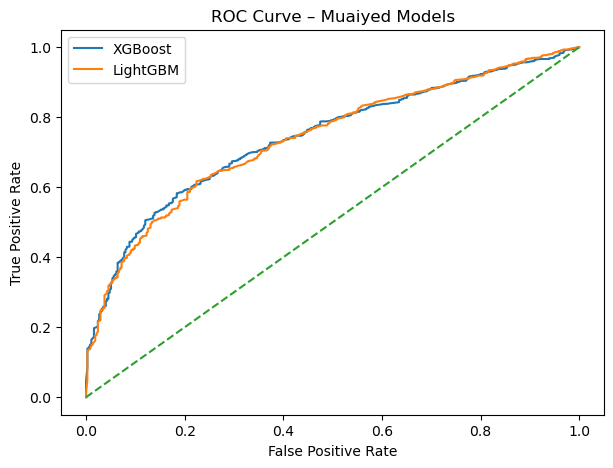

In [13]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)

plt.figure(figsize=(7,5))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM')
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Muaiyed Models")
plt.legend()
plt.show()


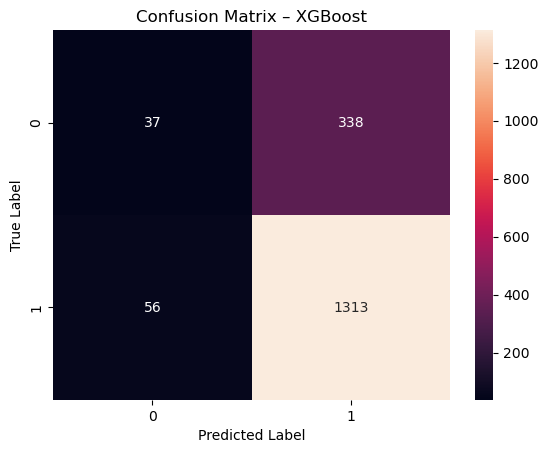

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d')
plt.title("Confusion Matrix – XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 7. Hiperparametre Optimizasyonu (RandomizedSearchCV)
LightGBM modelinin performansını daha da artırmak için `RandomizedSearchCV` kullanılarak en iyi parametreler (öğrenme oranı, ağaç derinliği, yaprak sayısı vb.) aranır. Bu işlem, modelin ezberlemesini (overfitting) önlemeye ve genelleme yeteneğini artırmaya yardımcı olur.

In [15]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    LGBMClassifier(random_state=42),
    param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
print("Best LightGBM Params:", search.best_params_)


[LightGBM] [Info] Number of positive: 5473, number of negative: 1502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 6975, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.784659 -> initscore=1.293029
[LightGBM] [Info] Start training from score 1.293029
Best LightGBM Params: {'num_leaves': 31, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01}


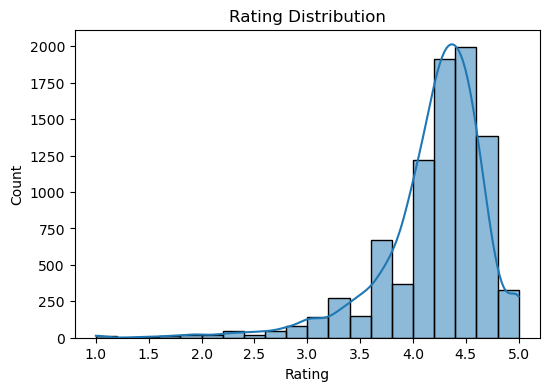

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title("Rating Distribution")
plt.show()


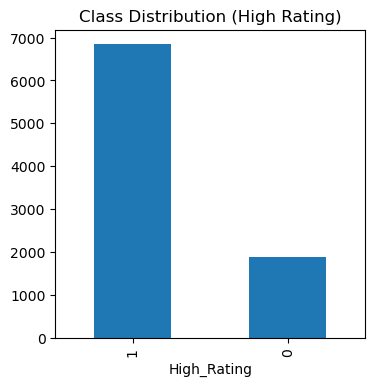

In [17]:
plt.figure(figsize=(4,4))
df['High_Rating'].value_counts().plot(kind='bar')
plt.title("Class Distribution (High Rating)")
plt.show()


In [18]:
features = ['Reviews', 'Installs', 'Price']
X = df[features]
y = df['High_Rating']

print("ROC AUC  :", X.describe())

ROC AUC  :             Reviews      Installs   Price
count  8.719000e+03  8.719000e+03  8719.0
mean   5.511243e+05  1.921717e+07     0.0
std    3.255360e+06  9.442960e+07     0.0
min    1.000000e+00  1.000000e+00     0.0
25%    2.370000e+02  1.000000e+04     0.0
50%    7.816000e+03  1.000000e+06     0.0
75%    9.653850e+04  5.000000e+06     0.0
max    7.815831e+07  1.000000e+09     0.0


In [19]:
print("\nTarget distribution (High_Rating):")
print(df["High_Rating"].value_counts())
print("\nTarget distribution (normalized):")
print(df["High_Rating"].value_counts(normalize=True))



Target distribution (High_Rating):
High_Rating
1    6842
0    1877
Name: count, dtype: int64

Target distribution (normalized):
High_Rating
1    0.784723
0    0.215277
Name: proportion, dtype: float64


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print("\n=== XGBoost Evaluation Results ===")
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1-Score :", f1_score(y_test, y_pred_xgb))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_xgb))



=== XGBoost Evaluation Results ===
Precision: 0.7952755905511811
Recall   : 0.9590942293644996
F1-Score : 0.8695364238410596
ROC AUC  : 0.7427143900657415


In [21]:
print("\n=== LightGBM Evaluation Results ===")
print("Precision:", precision_score(y_test, y_pred_lgbm))
print("Recall   :", recall_score(y_test, y_pred_lgbm))
print("F1-Score :", f1_score(y_test, y_pred_lgbm))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_lgbm))



=== LightGBM Evaluation Results ===
Precision: 0.7987804878048781
Recall   : 0.9569028487947406
F1-Score : 0.8707211698238617
ROC AUC  : 0.7392909666423181


### 8. Sonuçların Karşılaştırmalı Tablosu
XGBoost ve LightGBM modellerinin test seti üzerindeki sonuçları (**Precision**, **Recall**, **F1-Score** ve **ROC AUC**) bir tablo haline getirilerek hangi modelin bu problem için daha uygun olduğu belirlenir.

In [22]:
results_muaiyed = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM"],
    "Precision": [
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lgbm)
    ],
    "Recall": [
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lgbm)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgbm)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba_xgb),
        roc_auc_score(y_test, y_proba_lgbm)
    ]
})

print("\nMuaiyed Model Comparison Table:")
print(results_muaiyed.to_string(index=False))



Muaiyed Model Comparison Table:
   Model  Precision   Recall  F1-Score  ROC AUC
 XGBoost   0.795276 0.959094  0.869536 0.742714
LightGBM   0.798780 0.956903  0.870721 0.739291
